## Setting the environment

In [132]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np
import re
import nltk
from numpy import array

import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.layers import Conv1D
import joblib
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Activation, Dropout, Dense, Embedding, LSTM, Bidirectional

## Loading DataSet

In [133]:
reviews_data = pd.read_csv("../data/corrected_reviews.csv")
reviews_data.shape

(11639, 3)

In [134]:
reviews_data.head(5)

,Sentiments,Reviews,language
0,1,great original product great discount,en
1,0,trouser stuff good shirt poor quality,en
2,0,not leather jacket magazine quality not per de...,en
3,1,picture really good fabric received earlier gi...,en
4,0,fragrance short shelf life months started deve...,en


In [135]:
reviews_data = reviews_data.dropna(subset=['Reviews'])

In [136]:
# Checking for missing values

reviews_data.isnull().values.any()

False

In [137]:
with open('../data/stopwords.txt', 'r') as file:
    stopwords = {line.strip() for line in file}

<Axes: xlabel='Sentiments', ylabel='count'>

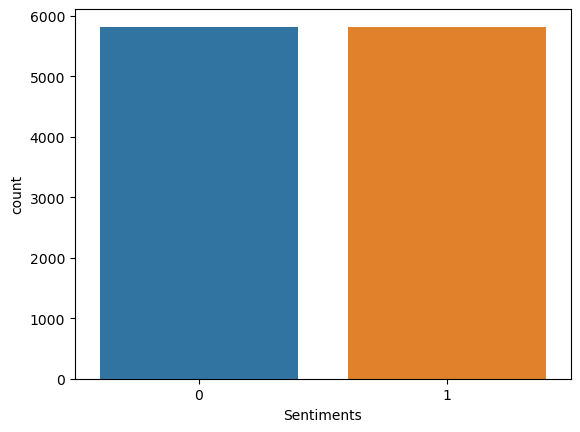

In [138]:
# Let's observe distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='Sentiments', data=reviews_data)

## Data Preprocessing

In [139]:
reviews_data["Reviews"][100]
# You can see that our text contains punctuations, brackets and numbers

'nice accessory pad pro honestly can without personally not going use much thought would not see use not artist something honest pen galaxy note amazing apple pencil honest opinion get use tireless magnetic keyboard came pad pro case pencil sending mine back getting refund'

In [140]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [141]:
#"not" plays an important role on reviews
contractions_dict = {
    r"don": "do not",
    r"doesn": "does not",
    r"didn": "did not",
    r"haven": "have not",
    r"hasn": "has not",
    r"hadn": "had not",
    r"won": "will not",
    r"wouldn": "would not",
    r"couldn": "could not",
    r"shouldn": "should not",
    r"mightn": "might not",
    r"mustn": "must not",
    r"weren": "were not",
    r"wasn": "was not",
    r"ain": "is not",
    r"won": "would not"
}
def expand_contractions(text):
    for contraction, expanded_form in contractions_dict.items():
        text = re.sub(contraction, expanded_form, text, flags=re.IGNORECASE)
    return text

In [142]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    #expanded forms
    sentence = expand_contractions(sentence)

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [143]:
# Calling preprocessing_text function on reviews_data

X = []
sentences = list(reviews_data['Reviews'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [144]:
# Sample cleaned up movie review 

X[100]

# As we shall use Word Embeddings, stemming/lemmatization is not performed as a preprocessing step here

'nice accessory pad pro honestly can without personally not going use much thought would not see use not artist something honest pen galaxy note amazing apple pencil honest opinion get use tireless magnetic keyboard came pad pro case pencil sending mine back getting refund'

In [145]:
reviews_data

,Sentiments,Reviews,language
0,1,great original product great discount,en
1,0,trouser stuff good shirt poor quality,en
2,0,not leather jacket magazine quality not per de...,en
3,1,picture really good fabric received earlier gi...,en
4,0,fragrance short shelf life months started deve...,en
...,...,...,...
11634,0,connected motordata pp year subscription carsc...,en
11635,1,ana best quality dismounted product excellent ...,en
11636,1,good quality one important thing want buy go b...,en
11637,1,useful storage,en


In [146]:
# Converting sentiment labels to 0 & 1
#y = np.array(list(map(lambda x: 1 if x=="positive" else 0, reviews_data['Sentiments'])))
y = reviews_data['Sentiments'].values

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Preparing Input layer

Let's now write the script for our embedding layer. Embedding layer converts our textual data into numeric form. It is then **used as the first layer for the deep learning models in Keras**.

In [148]:
# Embedding layer expects the words to be in numeric form 
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer 
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [149]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

5703

In [150]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

# Model Training with:

## Randoem Forest Classifier

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

RandomForestClassifier()

Training Accuracy : 0.99828141783029
Testing Accuracy : 0.7839347079037801


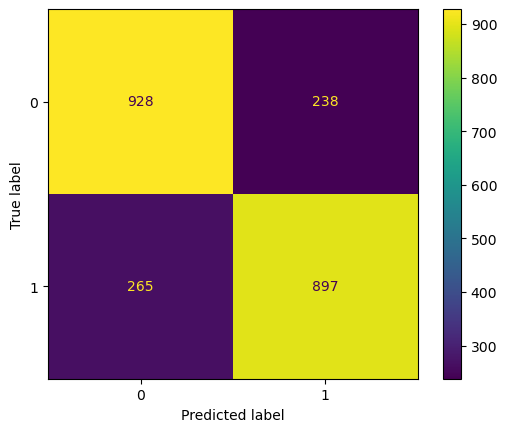

In [21]:
print("Training Accuracy :", model_rf.score(X_train, y_train))
print("Testing Accuracy :", model_rf.score(X_test, y_test))
y_preds = model_rf.predict(X_test)
cm = confusion_matrix(y_test, y_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

## Simple Neural Network

In [22]:
# Neural Network architecture

snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, input_length=maxlen)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

e:\anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [23]:
# Model compiling

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [24]:
# Model training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - acc: 0.5675 - loss: 0.6677 - val_acc: 0.8684 - val_loss: 0.4290
Epoch 2/6
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - acc: 0.8701 - loss: 0.3602 - val_acc: 0.9135 - val_loss: 0.2498
Epoch 3/6
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - acc: 0.9214 - loss: 0.2332 - val_acc: 0.9151 - val_loss: 0.2197
Epoch 4/6
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - acc: 0.9328 - loss: 0.1964 - val_acc: 0.9178 - val_loss: 0.2120
Epoch 5/6
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - acc: 0.9452 - loss: 0.1617 - val_acc: 0.9232 - val_loss: 0.2094
Epoch 6/6
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - acc: 0.9533 - loss: 0.1444 - val_acc: 0.9237 - val_loss: 0.2104


In [25]:
# Predictions on the Test Set

score = snn_model.evaluate(X_test, y_test, verbose=1)

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.9117 - loss: 0.2443


In [26]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.24525173008441925
Test Accuracy: 0.9097937941551208


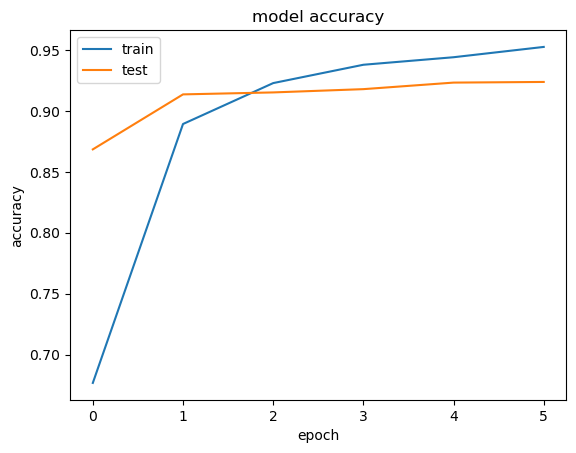

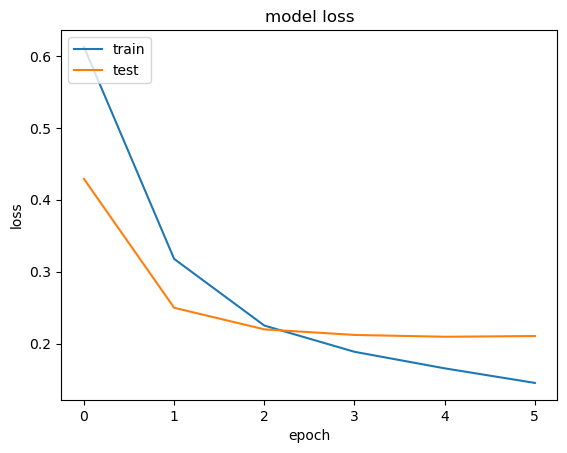

In [27]:
# Model Performance Charts

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Convolutional Neural Network

In [28]:
# Neural Network architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, input_length=maxlen)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [29]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [30]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=4, verbose=1, validation_split=0.2)

Epoch 1/4
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - acc: 0.7422 - loss: 0.5939 - val_acc: 0.9071 - val_loss: 0.2509
Epoch 2/4
59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - acc: 0.9158 - loss: 0.2277 - val_acc: 0.9232 - val_loss: 0.2032
Epoch 3/4
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - acc: 0.9450 - loss: 0.1554 - val_acc: 0.9189 - val_loss: 0.2037
Epoch 4/4
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - acc: 0.9587 - loss: 0.1264 - val_acc: 0.9194 - val_loss: 0.2171


In [31]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test)

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9095 - loss: 0.2520


In [32]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.2388180047273636
Test Accuracy: 0.9145188927650452


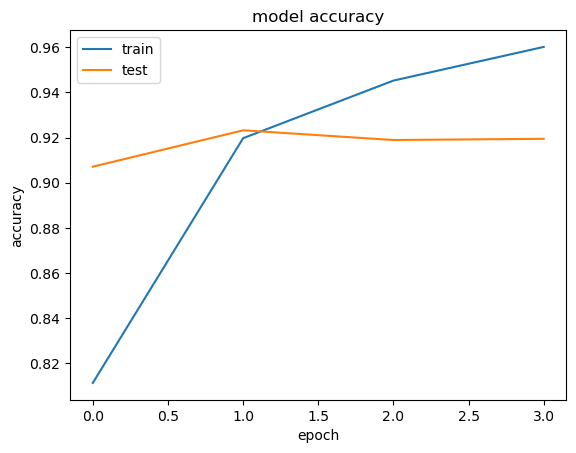

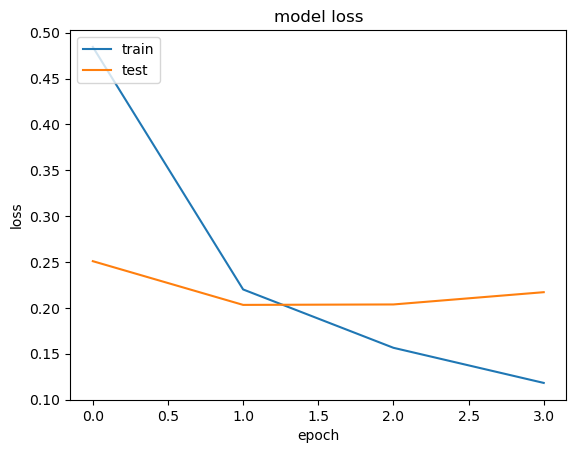

In [33]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [34]:
negative_reviews = [review for review in reviews_data[reviews_data['Sentiments'] == 0]['Reviews']]
negative_reviews

['trouser stuff good shirt poor quality',
 'not leather jacket magazine quality not per description ',
 'fragrance short shelf life months started develop unpleasant rapid smell disappointing invest fragrance go bad quickly expected better quality longevity ',
 'satisfied product good quality product',
 'look ordered received ',
 'good delivery time pages book not good quality fulfill purpose ',
 'ordered two size instead got one smaller size material used good belt fit well hence giving star rating ',
 'poor installation',
 'purchased football two days aback item seems detective press ball passes air solve although no return solve forwarded query instant chat even call tender phone number mentioned receipt nobody responded finally going return product ',
 'first box not come plastic pencil tip yellowish bent side connect pad not work can believe bought face apple product ',
 'received damaged would not connect charge complete rip apple would not replace aerial number would not come ac

In [35]:
negative_reviews_df = pd.DataFrame(negative_reviews, columns=['Review'])
negative_reviews_df

,Review
0,trouser stuff good shirt poor quality
1,not leather jacket magazine quality not per de...
2,fragrance short shelf life months started deve...
3,satisfied product good quality product
4,look ordered received
...,...
5813,pencil stopped charging stopped working right ...
5814,good quality touch material watch however show...
5815,ok not much ok ok sound good need improve pack...
5816,packing not fine


In [36]:
departments_keywords = {
    "Customer Service": [
        "service", "support", "customer service", "help", "response", "rude", "behavior", "polite", "agent", "call", "email",
        "assistance", "aid", "care", "courtesy", "treatment", "interaction", "representative", "communication", "reply", "feedback"
    ],
    "Product Quality": [
        "product", "quality", "defective", "broken", "durable", "material", "build", "manufacture", "craftsmanship", "faulty", "not working", "difficult",
        "item", "standard", "wastage","flawed", "damaged", "component", "construction", "production", "workmanship", "malfunctioning", "inoperative", "challenging"
    ],
    "Shipping": [
        "shipping", "delayed", "package", "sealed", "arrived", "late delivery", "courier", "tracking", "shipment", "dispatch", "fast", "slow",
        "delivery", "postponed", "parcel", "wrapped", "received", "carrier", "monitoring", "consignment", "send", "quick"
    ],
    "Technical Support": [
        "technical", "tech support", "IT", "software", "hardware", "bug", "issue", "glitch", "error", "malfunction", "install", "update",
        "technological", "technical assistance", "information technology", "program", "device", "fault", "problem", "flaw", "mistake", "breakdown", "setup", "upgrade"
    ],
    "Marketing": [
        "marketing", "advertising", "promotion", "campaign", "brand", "advertised", "strategy", "market", "target",
        "promotion", "publicity", "advertisement", "drive", "branding", "marketed"
    ],
    "Sales": [
        "sales", "purchase", "buy", "order", "pricing", "discount", "offer", "deal", "cost", "checkout", "price",
        "transactions", "acquisition", "procure", "command", "rate", "reduction", "proposal", "bargain", "expense", "payment", "value"
    ]
}


In [37]:
# Function to assign departments based on keywords
def assign_departments(review):
    assigned_departments = []
    for department, keywords in departments_keywords.items():
        if any(keyword in review.lower() for keyword in keywords):
            assigned_departments.append(department)
    return ', '.join(assigned_departments) if assigned_departments else "General"

In [38]:
negative_reviews_df['Departments'] = negative_reviews_df['Review'].apply(assign_departments)

In [39]:
#negative_reviews_df.to_csv("departments.csv")

In [151]:
embedding_dim = 100
lstm_units = 128
dropout = 0.4

In [152]:
model = Sequential()
model.add(Embedding(vocab_length, embedding_dim, input_length=maxlen))
model.add(Dropout(dropout))

model.add(Bidirectional(LSTM(lstm_units, return_sequences=True)))
model.add(Dropout(dropout))

model.add(Bidirectional(LSTM(lstm_units, return_sequences=True)))
model.add(Dropout(dropout))

model.add(Bidirectional(LSTM(lstm_units)))
model.add(Dropout(dropout))

model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train model
rnn_model_history = model.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.2, callbacks=[early_stopping])

# Evaluate model
score = model.evaluate(X_test, y_test)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

e:\anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 287s 2s/step - accuracy: 0.5644 - loss: 0.6758 - val_accuracy: 0.8808 - val_loss: 0.3080
Epoch 2/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.8679 - loss: 0.3260 - val_accuracy: 0.9055 - val_loss: 0.2409
Epoch 3/10
 86/117 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - accuracy: 0.9033 - loss: 0.2528

KeyboardInterrupt: 

In [67]:
# Model Performance Charts (add these lines after the CNN model plots)

plt.plot(model.history['acc'])
plt.plot(model.history['val_acc'])

plt.title('RNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


TypeError: 'History' object is not subscriptable

In [ ]:
plt.plot(rnn_model_history.history['loss'])
plt.plot(rnn_model_history.history['val_loss'])

plt.title('RNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'rnn_model_history' is not defined

In [ ]:
joblib.dump(model, 'model.pkl')

['model.pkl']